<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/6_2_attitude_steerability_polviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 6.2: Attitude Steerability (Political Views)

**Research Question:** How does the Extremely Conservative vs Extremely Liberal steering vector compare to the Strong Republican vs Strong Democrat vector (Phase 6.1) in steering LLM attitudes to match real-world GSS distributions?

Phase 6.1 used `PartyID_Strong Republican - PartyID_Strong Democrat` as the contrastive steering vector and compared against GSS distributions broken down by party ID. This notebook replicates the same experiment using `PolViews_extremely conservative - PolViews_extremely liberal` as the steering vector and compares against GSS distributions broken down by political views (7 categories from Extremely Liberal to Extremely Conservative).

In [1]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 22.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
BASE_DIR = '/content/drive/MyDrive/belief_and_llms_v0'
VECTOR_DIR = os.path.join(BASE_DIR, 'vectors')
DATA_DIR = os.path.join(BASE_DIR, 'data')

# Constants
STEERING_LAYER = 13
STRENGTHS = np.arange(-5.0, 5.5, 0.5)

# Load model
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map='auto',
    torch_dtype=torch.float16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
print('Model loaded.')

# Load contrastive steering vector: Extremely Conservative - Extremely Liberal
demo_vectors = torch.load(
    os.path.join(VECTOR_DIR, f'gss_demographic_vectors_layer{STEERING_LAYER}.pt'),
    map_location='cpu', weights_only=True,
)
v_con = demo_vectors['PolViews_person with an extremely conservative political view']['vector']
v_lib = demo_vectors['PolViews_person with an extremely liberal political view']['vector']
contrastive_vec = v_con - v_lib
print(f'Contrastive vector (Ext Conservative - Ext Liberal) magnitude: {contrastive_vec.norm():.4f}')

# Also load PartyID vector for comparison
v_rep = demo_vectors['PartyID_Strong Republican']['vector']
v_dem = demo_vectors['PartyID_Strong Democrat']['vector']
partyid_vec = v_rep - v_dem
cos_sim = F.cosine_similarity(contrastive_vec.unsqueeze(0), partyid_vec.unsqueeze(0)).item()
print(f'PartyID contrastive vector magnitude: {partyid_vec.norm():.4f}')
print(f'Cosine similarity (PolViews vs PartyID contrastive): {cos_sim:.4f}')
print(f'Steering strengths: {STRENGTHS[0]:.1f} to {STRENGTHS[-1]:.1f} (step 0.5, {len(STRENGTHS)} values)')

Mounted at /content/drive


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded.
Contrastive vector (Ext Conservative - Ext Liberal) magnitude: 0.4229
PartyID contrastive vector magnitude: 0.3403
Cosine similarity (PolViews vs PartyID contrastive): 0.5791
Steering strengths: -5.0 to 5.0 (step 0.5, 21 values)


In [3]:
# All 34 attitude variable configurations (same as Phase 6.1)
ATTITUDE_CONFIGS = {
    # === Binary Variables ===
    'abortion': {
        'gss_col': 'abany',
        'option_a_label': 'Pro-choice',
        'option_b_label': 'Pro-life',
        'option_a_values': ['YES'],
        'option_b_values': ['NO'],
        'binary_prompt': '[INST] What is your stance on abortion? [/INST]\n(A) Pro-choice (woman should have the right to choose)\n(B) Pro-life (abortion should be restricted or banned)\nAnswer:',
    },
    'gun_control': {
        'gss_col': 'gunlaw',
        'option_a_label': 'Stricter control',
        'option_b_label': 'Gun rights',
        'option_a_values': ['FAVOR'],
        'option_b_values': ['OPPOSE'],
        'binary_prompt': '[INST] What is your stance on gun control? [/INST]\n(A) Support stricter gun control laws\n(B) Protect Second Amendment gun rights\nAnswer:',
    },
    'death_penalty': {
        'gss_col': 'cappun',
        'option_a_label': 'Oppose',
        'option_b_label': 'Favor',
        'option_a_values': ['OPPOSE'],
        'option_b_values': ['FAVOR'],
        'binary_prompt': '[INST] What is your stance on the death penalty for persons convicted of murder? [/INST]\n(A) Oppose the death penalty\n(B) Favor the death penalty\nAnswer:',
    },
    'same_sex_marriage': {
        'gss_col': 'MARSAME1',
        'option_a_label': 'Support',
        'option_b_label': 'Oppose',
        'option_a_values': ['Strongly agree', 'Agree'],
        'option_b_values': ['Disagree', 'Strongly disagree'],
        'binary_prompt': '[INST] What is your stance on same-sex marriage? [/INST]\n(A) Support (same-sex couples should have the right to marry)\n(B) Oppose (marriage should be between a man and a woman)\nAnswer:',
    },
    'free_speech_racists': {
        'gss_col': 'librac',
        'option_a_label': 'Allow',
        'option_b_label': 'Censor',
        'option_a_values': ['NOT REMOVE'],
        'option_b_values': ['REMOVE'],
        'binary_prompt': '[INST] Should a book written by a racist be removed from the public library? [/INST]\n(A) Should not be removed (allow racist speech)\n(B) Should be removed (censor racist speech)\nAnswer:',
    },
    'free_speech_atheists': {
        'gss_col': 'libath',
        'option_a_label': 'Allow',
        'option_b_label': 'Censor',
        'option_a_values': ['NOT REMOVE'],
        'option_b_values': ['REMOVE'],
        'binary_prompt': '[INST] Should a book written against churches and religion be removed from the public library? [/INST]\n(A) Should not be removed (allow atheist speech)\n(B) Should be removed (censor atheist speech)\nAnswer:',
    },
    'marijuana': {
        'gss_col': 'grass',
        'option_a_label': 'Legal',
        'option_b_label': 'Illegal',
        'option_a_values': ['Should be legal'],
        'option_b_values': ['Should not be legal'],
        'binary_prompt': '[INST] Do you think the use of marijuana should be made legal or not? [/INST]\n(A) Should be made legal\n(B) Should not be made legal\nAnswer:',
    },
    'euthanasia': {
        'gss_col': 'letdie1',
        'option_a_label': 'Right to die',
        'option_b_label': 'No right to die',
        'option_a_values': ['YES'],
        'option_b_values': ['NO'],
        'binary_prompt': '[INST] When a person has an incurable disease, should doctors be allowed by law to end the patient\'s life if the patient and family request it? [/INST]\n(A) Yes, doctors should be allowed\n(B) No, doctors should not be allowed\nAnswer:',
    },
    'work_ethic_if_rich': {
        'gss_col': 'richwork',
        'option_a_label': 'Continue working',
        'option_b_label': 'Stop working',
        'option_a_values': ['Continue to work'],
        'option_b_values': ['Stop working'],
        'binary_prompt': '[INST] If you were to get enough money to live comfortably for the rest of your life, would you continue to work or stop working? [/INST]\n(A) Continue to work\n(B) Stop working\nAnswer:',
    },

    # === 3-Option Variables (collapse to 2 extremes) ===
    'spending_space': {
        'gss_col': 'natspac',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on the space exploration program? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_environment': {
        'gss_col': 'natenvir',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on improving and protecting the environment? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_crime': {
        'gss_col': 'natcrime',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on halting the rising crime rate? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_drugs': {
        'gss_col': 'natdrug',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on dealing with drug addiction? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_education': {
        'gss_col': 'nateduc',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on improving the nation\'s education system? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_race': {
        'gss_col': 'natrace',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on improving the conditions of Black Americans? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_military': {
        'gss_col': 'natarms',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on the military, armaments, and defense? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'spending_welfare': {
        'gss_col': 'natfare',
        'option_a_label': 'Too little',
        'option_b_label': 'Too much',
        'option_a_values': ['TOO LITTLE'],
        'option_b_values': ['TOO MUCH'],
        'binary_prompt': '[INST] Do you think we are spending too much, too little, or about the right amount on welfare? [/INST]\n(A) Too little\n(B) Too much\nAnswer:',
    },
    'court_harshness': {
        'gss_col': 'courts',
        'option_a_label': 'Too harsh',
        'option_b_label': 'Not harsh enough',
        'option_a_values': ['Too harshly'],
        'option_b_values': ['Not harshly enough'],
        'binary_prompt': '[INST] In general, do you think the courts in this area deal too harshly or not harshly enough with criminals? [/INST]\n(A) Too harshly\n(B) Not harshly enough\nAnswer:',
    },
    'bible': {
        'gss_col': 'bible',
        'option_a_label': 'Word of God',
        'option_b_label': 'Book of fables',
        'option_a_values': ['Word of god'],
        'option_b_values': ['Ancient book'],
        'binary_prompt': '[INST] Which of these statements comes closest to describing your feelings about the Bible? [/INST]\n(A) The Bible is the actual word of God and is to be taken literally\n(B) The Bible is an ancient book of fables, legends, history, and moral precepts\nAnswer:',
    },
    'trust': {
        'gss_col': 'trust',
        'option_a_label': 'Can be trusted',
        'option_b_label': "Can't be careful",
        'option_a_values': ['Most people can be trusted'],
        'option_b_values': ["Can't be too careful"],
        'binary_prompt': '[INST] Generally speaking, would you say that most people can be trusted or that you can\'t be too careful in dealing with people? [/INST]\n(A) Most people can be trusted\n(B) Can\'t be too careful\nAnswer:',
    },
    'fairness': {
        'gss_col': 'fair',
        'option_a_label': 'Fair',
        'option_b_label': 'Take advantage',
        'option_a_values': ['Would try to be fair'],
        'option_b_values': ['Would take advantage of you'],
        'binary_prompt': '[INST] Do you think most people would try to take advantage of you if they got a chance, or would they try to be fair? [/INST]\n(A) Would try to be fair\n(B) Would try to take advantage\nAnswer:',
    },
    'open_housing': {
        'gss_col': 'racopen',
        'option_a_label': 'Anti-discrimination',
        'option_b_label': 'Allow discrimination',
        'option_a_values': ['Second law'],
        'option_b_values': ['First law'],
        'binary_prompt': '[INST] Suppose there is a community-wide vote on housing policy. Which law would you vote for? [/INST]\n(A) A homeowner cannot refuse to sell to someone because of their race or color (anti-discrimination law)\n(B) A homeowner can decide for themselves whom to sell their house to, even if they prefer not to sell to certain races (right to discriminate)\nAnswer:',
    },

    # === Scale Variables (collapse extreme ends) ===
    'income_equality': {
        'gss_col': 'eqwlth',
        'option_a_label': 'Govt reduce',
        'option_b_label': 'Govt not reduce',
        'option_a_values': ['The government should reduce income differences', '2'],
        'option_b_values': ['6', 'The government should not concern itself with reducing income differences'],
        'binary_prompt': '[INST] Some people think that the government should reduce income differences between the rich and poor. Others think the government should not concern itself with this. What do you think? [/INST]\n(A) The government should reduce income differences\n(B) The government should not concern itself with reducing income differences\nAnswer:',
    },
    'help_poor': {
        'gss_col': 'helppoor',
        'option_a_label': 'Govt action',
        'option_b_label': 'Self-help',
        'option_a_values': ['GOVT ACTION', '2'],
        'option_b_values': ['4', 'PEOPLE HELP SELVES'],
        'binary_prompt': '[INST] Some people think that the government should do everything possible to improve the standard of living of all poor Americans. Others think it is not the government\'s responsibility. What do you think? [/INST]\n(A) Government should act to improve the poor\'s standard of living\n(B) People should help themselves\nAnswer:',
    },
    'healthcare': {
        'gss_col': 'helpsick',
        'option_a_label': 'Govt help',
        'option_b_label': 'Self-help',
        'option_a_values': ['GOVT SHOULD HELP', '2'],
        'option_b_values': ['4', 'PEOPLE HELP SELVES'],
        'binary_prompt': '[INST] Some people think the government should help pay for medical care. Others think people should take care of themselves. What do you think? [/INST]\n(A) Government should help pay for medical care\n(B) People should help themselves\nAnswer:',
    },
    'world_good_evil': {
        'gss_col': 'world1',
        'option_a_label': 'Good',
        'option_b_label': 'Evil',
        'option_a_values': ['WORLD IS GOOD', '2'],
        'option_b_values': ['6', 'WORLD IS EVIL'],
        'binary_prompt': '[INST] Would you say that the world is basically filled with goodness, or would you say that there is much evil in the world? [/INST]\n(A) The world is basically good\n(B) The world is basically evil\nAnswer:',
    },
    'people_good_evil': {
        'gss_col': 'world4',
        'option_a_label': 'Good',
        'option_b_label': 'Evil',
        'option_a_values': ['PEOPLE ARE GOOD', '2'],
        'option_b_values': ['6', 'PEOPLE ARE EVIL'],
        'binary_prompt': '[INST] Would you say that human nature is basically good, or that it is fundamentally perverse and corrupt? [/INST]\n(A) Human nature is basically good\n(B) Human nature is fundamentally perverse and corrupt\nAnswer:',
    },
    'perception_whites': {
        'gss_col': 'workwhts',
        'option_a_label': 'Hard-working',
        'option_b_label': 'Lazy',
        'option_a_values': ['1 - Hard-working', '2'],
        'option_b_values': ['6', '7 - Lazy'],
        'binary_prompt': '[INST] On a scale from hard-working to lazy, where would you rate white people in general? [/INST]\n(A) Hard-working\n(B) Lazy\nAnswer:',
    },
    'perception_blacks': {
        'gss_col': 'workblks',
        'option_a_label': 'Hard-working',
        'option_b_label': 'Lazy',
        'option_a_values': ['1 - Hard-working', '2'],
        'option_b_values': ['6', '7 - Lazy'],
        'binary_prompt': '[INST] On a scale from hard-working to lazy, where would you rate Black people in general? [/INST]\n(A) Hard-working\n(B) Lazy\nAnswer:',
    },
    'perception_hispanics': {
        'gss_col': 'workhsps',
        'option_a_label': 'Hard-working',
        'option_b_label': 'Lazy',
        'option_a_values': ['1 - Hard-working', '2'],
        'option_b_values': ['6', '7 - Lazy'],
        'binary_prompt': '[INST] On a scale from hard-working to lazy, where would you rate Hispanic people in general? [/INST]\n(A) Hard-working\n(B) Lazy\nAnswer:',
    },

    # === 4-Option Variables (collapse to 2 groups) ===
    'affirmative_action': {
        'gss_col': 'affrmact',
        'option_a_label': 'Favor',
        'option_b_label': 'Oppose',
        'option_a_values': ['Strongly favors', 'Not strongly favors'],
        'option_b_values': ['Not strongly opposes', 'Strongly opposes'],
        'binary_prompt': '[INST] What about preferential hiring and promotion of Black Americans? Do you favor or oppose it? [/INST]\n(A) Favor affirmative action\n(B) Oppose affirmative action\nAnswer:',
    },
    'premarital_sex': {
        'gss_col': 'premarsx',
        'option_a_label': 'Not wrong',
        'option_b_label': 'Wrong',
        'option_a_values': ['NOT WRONG AT ALL', 'SOMETIMES WRONG'],
        'option_b_values': ['ALMST ALWAYS WRG', 'ALWAYS WRONG'],
        'binary_prompt': '[INST] If a man and woman have sexual relations before marriage, do you think it is wrong or not wrong? [/INST]\n(A) Not wrong at all or sometimes wrong\n(B) Almost always or always wrong\nAnswer:',
    },
    'extramarital_sex': {
        'gss_col': 'xmarsex',
        'option_a_label': 'Not wrong',
        'option_b_label': 'Wrong',
        'option_a_values': ['NOT WRONG AT ALL', 'SOMETIMES WRONG'],
        'option_b_values': ['ALMST ALWAYS WRG', 'ALWAYS WRONG'],
        'binary_prompt': '[INST] What about a married person having sexual relations with someone other than the marriage partner? Is it wrong or not wrong? [/INST]\n(A) Not wrong at all or sometimes wrong\n(B) Almost always or always wrong\nAnswer:',
    },
    'spanking': {
        'gss_col': 'spanking',
        'option_a_label': 'Appropriate',
        'option_b_label': 'Not appropriate',
        'option_a_values': ['STRONGLY AGREE', 'AGREE'],
        'option_b_values': ['DISAGREE', 'STRONGLY DISAGREE'],
        'binary_prompt': '[INST] Do you strongly agree, agree, disagree, or strongly disagree that it is sometimes necessary to discipline a child with a good, hard spanking? [/INST]\n(A) Agree (spanking is sometimes necessary)\n(B) Disagree (spanking is not appropriate)\nAnswer:',
    },
}

# Group assignments for visualization
VARIABLE_GROUPS = {
    'Social issues': ['abortion', 'gun_control', 'death_penalty', 'same_sex_marriage',
                      'marijuana', 'euthanasia', 'premarital_sex', 'extramarital_sex',
                      'spanking', 'free_speech_racists', 'free_speech_atheists'],
    'Spending': ['spending_space', 'spending_environment', 'spending_crime', 'spending_drugs',
                 'spending_education', 'spending_race', 'spending_military', 'spending_welfare'],
    'Other attitudes': ['income_equality', 'help_poor', 'healthcare', 'court_harshness',
                        'bible', 'trust', 'fairness', 'open_housing',
                        'affirmative_action', 'work_ethic_if_rich',
                        'world_good_evil', 'people_good_evil',
                        'perception_whites', 'perception_blacks', 'perception_hispanics'],
}

print(f'Defined {len(ATTITUDE_CONFIGS)} attitude variable configs')
for group, vars_ in VARIABLE_GROUPS.items():
    print(f'  {group}: {len(vars_)} variables')

Defined 34 attitude variable configs
  Social issues: 11 variables
  Spending: 8 variables
  Other attitudes: 15 variables


In [4]:
# Load GSS data and compute real-world probabilities by political views
gss_df = pd.read_excel(os.path.join(DATA_DIR, 'GSS.xlsx'))
print(f'Loaded GSS data: {len(gss_df)} rows')

# Political views mapping (string values in GSS.xlsx)
POLVIEWS_MAPPING = {
    'Extremely Liberal': 'Extremely liberal',
    'Liberal': 'Liberal',
    'Slightly Liberal': 'Slightly liberal',
    'Moderate': 'Moderate, middle of the road',
    'Slightly Conservative': 'Slightly conservative',
    'Conservative': 'Conservative',
    'Extremely Conservative': 'Extremely conservative',
}

POLVIEWS_COLORS = {
    'Extremely Liberal': '#0015BC',
    'Liberal': '#4466DD',
    'Slightly Liberal': '#6699FF',
    'Moderate': '#808080',
    'Slightly Conservative': '#FF8888',
    'Conservative': '#DD4444',
    'Extremely Conservative': '#E81B23',
}

def compute_gss_probability(gss_df, config, polviews_gss_value=None):
    """Compute P(Option A) for a given attitude variable and optional polviews filter."""
    col = config['gss_col']
    if col not in gss_df.columns:
        return None, 0

    df = gss_df if polviews_gss_value is None else gss_df[gss_df['polviews'] == polviews_gss_value]

    valid_values = config['option_a_values'] + config['option_b_values']
    valid_df = df[df[col].isin(valid_values)]

    if len(valid_df) == 0:
        return None, 0

    option_a_count = valid_df[col].isin(config['option_a_values']).sum()
    return option_a_count / len(valid_df), len(valid_df)

# Compute probabilities for all variables and polviews categories
gss_probs = {}
header = f'{"Variable":<25s} {"GSS col":<12s}'
for pv in POLVIEWS_MAPPING:
    header += f' {pv[:7]:>8s}'
header += f' {"Overall":>8s}'
print(f'\n{header}')
print('-' * (25 + 12 + 8 * (len(POLVIEWS_MAPPING) + 1) + len(POLVIEWS_MAPPING) + 1))

skipped = []
for var_name, config in ATTITUDE_CONFIGS.items():
    gss_probs[var_name] = {}

    row = f'{var_name:<25s} {config["gss_col"]:<12s}'
    for pv_label, pv_gss_val in POLVIEWS_MAPPING.items():
        prob, n = compute_gss_probability(gss_df, config, pv_gss_val)
        gss_probs[var_name][pv_label] = {'prob_a': prob, 'n': n}
        row += f' {prob:>7.1%}' if prob is not None else f' {"N/A":>7s}'

    prob_all, n_all = compute_gss_probability(gss_df, config)
    gss_probs[var_name]['Overall'] = {'prob_a': prob_all, 'n': n_all}
    row += f' {prob_all:>7.1%}' if prob_all is not None else f' {"N/A":>7s}'

    if prob_all is None:
        skipped.append(var_name)
    print(row)

if skipped:
    print(f'\nSkipped (column not found): {skipped}')

Loaded GSS data: 75699 rows

Variable                  GSS col       Extreme  Liberal  Slightl  Moderat  Slightl  Conserv  Extreme  Overall
-------------------------------------------------------------------------------------------------------------
abortion                  abany          69.8%   64.8%   55.1%   43.2%   37.6%   26.3%   23.6%   43.3%
gun_control               gunlaw         81.2%   83.9%   81.7%   76.5%   71.8%   63.9%   59.7%   75.0%
death_penalty             cappun         58.4%   48.3%   38.2%   28.3%   24.0%   20.0%   21.0%   31.0%
same_sex_marriage         MARSAME1       79.7%   83.2%   75.0%   61.0%   49.7%   27.3%   23.4%   57.4%
free_speech_racists       librac         68.5%   70.1%   70.2%   62.4%   66.7%   61.9%   55.8%   64.5%
free_speech_atheists      libath         81.1%   80.8%   77.8%   69.2%   71.5%   64.8%   55.9%   70.0%
marijuana                 grass          62.4%   53.7%   41.9%   33.4%   28.2%   22.2%   23.5%   33.6%
euthanasia                let

In [5]:
# Steering functions (reused from Phase 3.1)

def get_binary_choice_prob(prompt, steering_vector, strength, layer_idx):
    """Get P(A) vs P(B) with steering applied via forward hook."""
    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    steer_vec = steering_vector.to(model.device).to(model.dtype)

    def steering_hook(module, input, output):
        perturbation = steer_vec.view(1, 1, -1) * strength
        if isinstance(output, tuple):
            return (output[0] + perturbation,) + output[1:]
        elif isinstance(output, torch.Tensor):
            return output + perturbation
        return output

    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(steering_hook)
    try:
        with torch.no_grad():
            outputs = model(**inputs)
    finally:
        handle.remove()

    next_token_logits = outputs.logits[0, -1, :]
    id_a = tokenizer.encode(' A', add_special_tokens=False)[-1]
    id_b = tokenizer.encode(' B', add_special_tokens=False)[-1]
    probs = F.softmax(torch.tensor([next_token_logits[id_a], next_token_logits[id_b]]), dim=0)
    return probs[0].item()


def find_optimal_strength(llm_results_df, target_prob):
    """Find steering strength that produces P(A) closest to target."""
    if target_prob is None:
        return None, None
    errors = np.abs(llm_results_df['prob_a'].values - target_prob)
    best_idx = np.argmin(errors)
    return llm_results_df.iloc[best_idx]['strength'], errors[best_idx]


print('Steering functions defined.')

Steering functions defined.


In [6]:
# Run steering sweep for all 34 variables

active_vars = [v for v in ATTITUDE_CONFIGS if gss_probs[v]['Overall']['prob_a'] is not None]
print(f'Running steering sweep for {len(active_vars)} variables with valid GSS data')
print(f'Strengths: {STRENGTHS[0]:.1f} to {STRENGTHS[-1]:.1f} ({len(STRENGTHS)} values)')
print(f'Total forward passes: {len(active_vars) * len(STRENGTHS)}')

llm_steering_results = {}

for i, var_name in enumerate(active_vars):
    config = ATTITUDE_CONFIGS[var_name]
    prompt = config['binary_prompt']

    results = []
    for strength in STRENGTHS:
        prob_a = get_binary_choice_prob(prompt, contrastive_vec, strength, STEERING_LAYER)
        results.append({'strength': strength, 'prob_a': prob_a})

    llm_steering_results[var_name] = pd.DataFrame(results)
    print(f'  [{i+1}/{len(active_vars)}] {var_name}: '
          f'P(A) range = {llm_steering_results[var_name]["prob_a"].min():.3f} \u2013 '
          f'{llm_steering_results[var_name]["prob_a"].max():.3f}')

# Save results
save_path = os.path.join(DATA_DIR, 'attitude_steerability_polviews_results.pt')
torch.save({
    'llm_steering_results': {k: v.to_dict() for k, v in llm_steering_results.items()},
    'gss_probs': gss_probs,
    'strengths': STRENGTHS.tolist(),
    'steering_layer': STEERING_LAYER,
    'steering_vector': 'PolViews_ExtConservative_minus_ExtLiberal',
}, save_path)
print(f'\nResults saved to {save_path}')

Running steering sweep for 34 variables with valid GSS data
Strengths: -5.0 to 5.0 (21 values)
Total forward passes: 714
  [1/34] abortion: P(A) range = 0.644 – 0.834
  [2/34] gun_control: P(A) range = 0.482 – 0.655
  [3/34] death_penalty: P(A) range = 0.404 – 0.531
  [4/34] same_sex_marriage: P(A) range = 0.895 – 0.910
  [5/34] free_speech_racists: P(A) range = 0.110 – 0.662
  [6/34] free_speech_atheists: P(A) range = 0.994 – 0.997
  [7/34] marijuana: P(A) range = 0.839 – 0.938
  [8/34] euthanasia: P(A) range = 0.658 – 0.820
  [9/34] work_ethic_if_rich: P(A) range = 0.127 – 0.570
  [10/34] spending_space: P(A) range = 0.679 – 0.843
  [11/34] spending_environment: P(A) range = 0.935 – 0.963
  [12/34] spending_crime: P(A) range = 0.860 – 0.928
  [13/34] spending_drugs: P(A) range = 0.890 – 0.936
  [14/34] spending_education: P(A) range = 0.920 – 0.957
  [15/34] spending_race: P(A) range = 0.969 – 0.985
  [16/34] spending_military: P(A) range = 0.169 – 0.321
  [17/34] spending_welfare: P

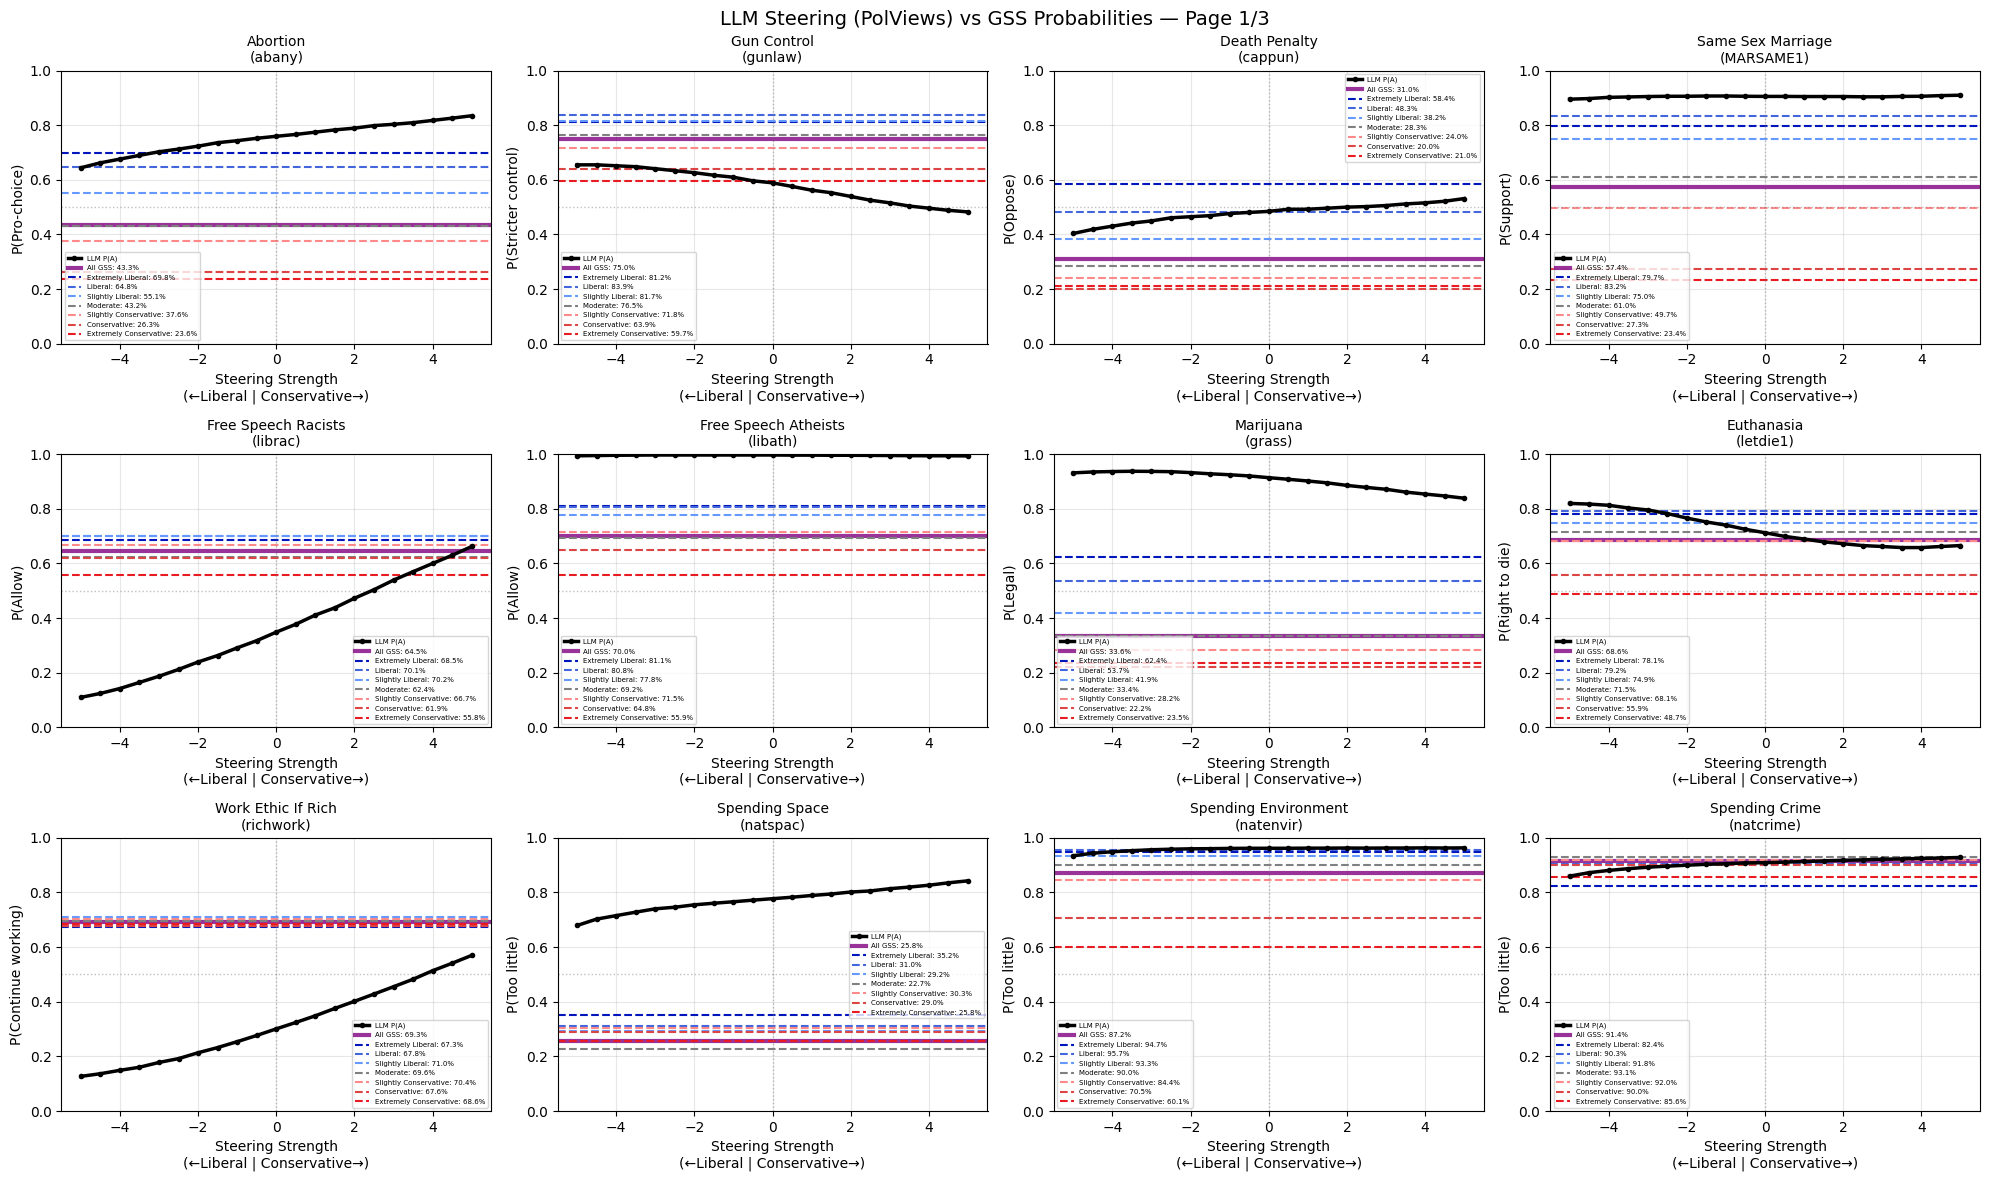

In [7]:
# Visualize: LLM Steering Curves + GSS Target Lines (Page 1: Variables 1-12)
active_vars = list(llm_steering_results.keys())

def plot_steering_page(var_names, page_num, total_pages):
    n = len(var_names)
    ncols = 4
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4 * nrows))
    axes = axes.flatten() if nrows > 1 else (axes if n > 1 else [axes])

    for idx, var_name in enumerate(var_names):
        ax = axes[idx]
        config = ATTITUDE_CONFIGS[var_name]
        llm_df = llm_steering_results[var_name]
        var_gss = gss_probs[var_name]

        # LLM steering curve
        ax.plot(llm_df['strength'], llm_df['prob_a'], 'k-o', linewidth=2.5, markersize=3,
                label='LLM P(A)', zorder=10)

        # Overall GSS line
        overall = var_gss.get('Overall', {})
        if overall.get('prob_a') is not None:
            ax.axhline(y=overall['prob_a'], color='purple', linestyle='-', linewidth=3, alpha=0.8,
                       label=f'All GSS: {overall["prob_a"]:.1%}')

        # Per-polviews GSS lines
        for pv_name in POLVIEWS_MAPPING:
            pv_data = var_gss.get(pv_name, {})
            if pv_data.get('prob_a') is not None:
                ax.axhline(y=pv_data['prob_a'], color=POLVIEWS_COLORS[pv_name],
                           linestyle='--', linewidth=1.5,
                           label=f'{pv_name}: {pv_data["prob_a"]:.1%}')

        ax.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        ax.set_xlabel('Steering Strength\n(\u2190Liberal | Conservative\u2192)')
        ax.set_ylabel(f'P({config["option_a_label"]})')
        ax.set_title(f'{var_name.replace("_", " ").title()}\n({config["gss_col"]})', fontsize=10)
        ax.set_ylim(0, 1)
        ax.legend(loc='best', fontsize=5)
        ax.grid(True, alpha=0.3)

    for idx in range(n, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle(f'LLM Steering (PolViews) vs GSS Probabilities \u2014 Page {page_num}/{total_pages}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Page 1
plot_steering_page(active_vars[:12], 1, 3)

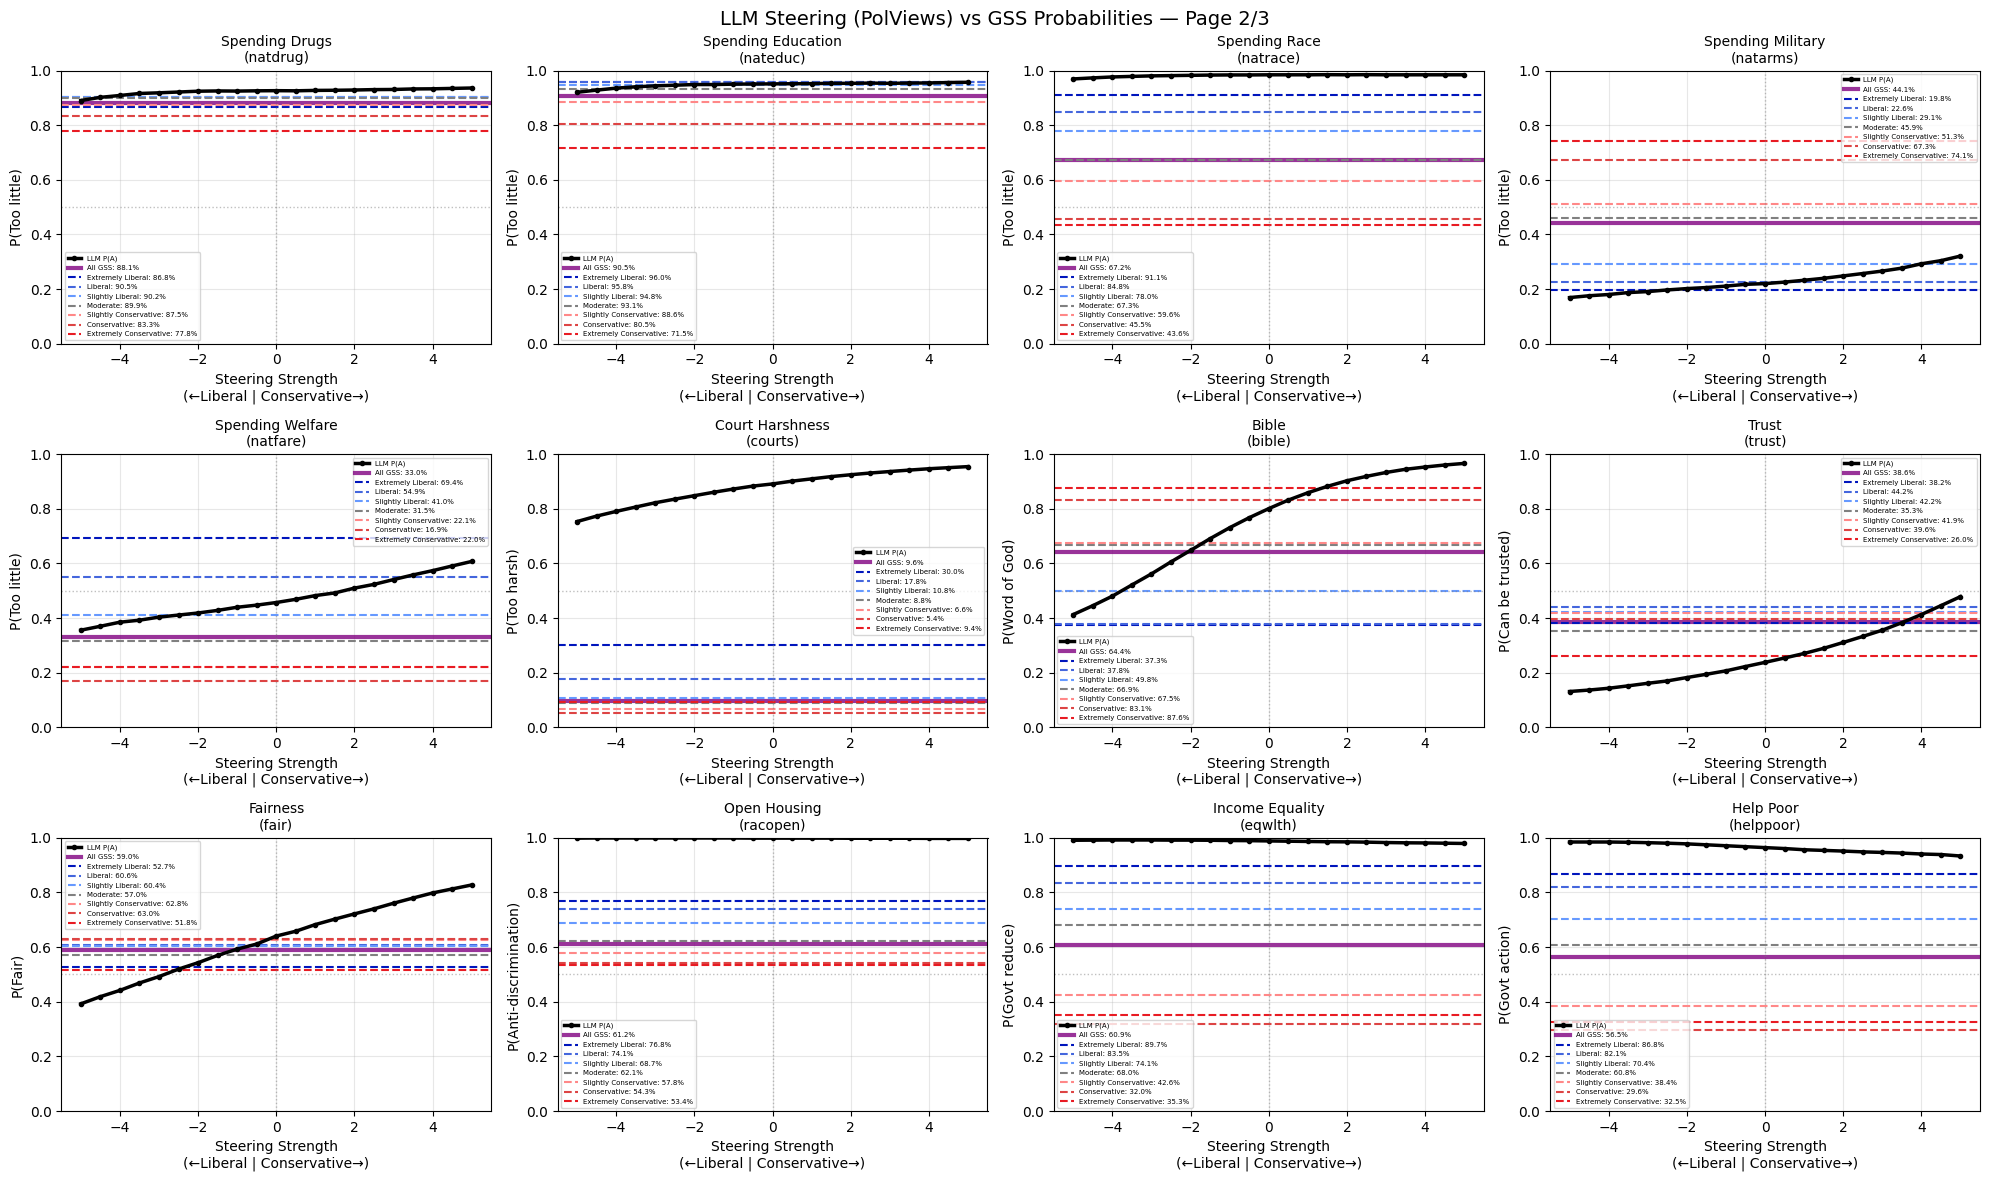

In [8]:
# Page 2: Variables 13-24
plot_steering_page(active_vars[12:24], 2, 3)

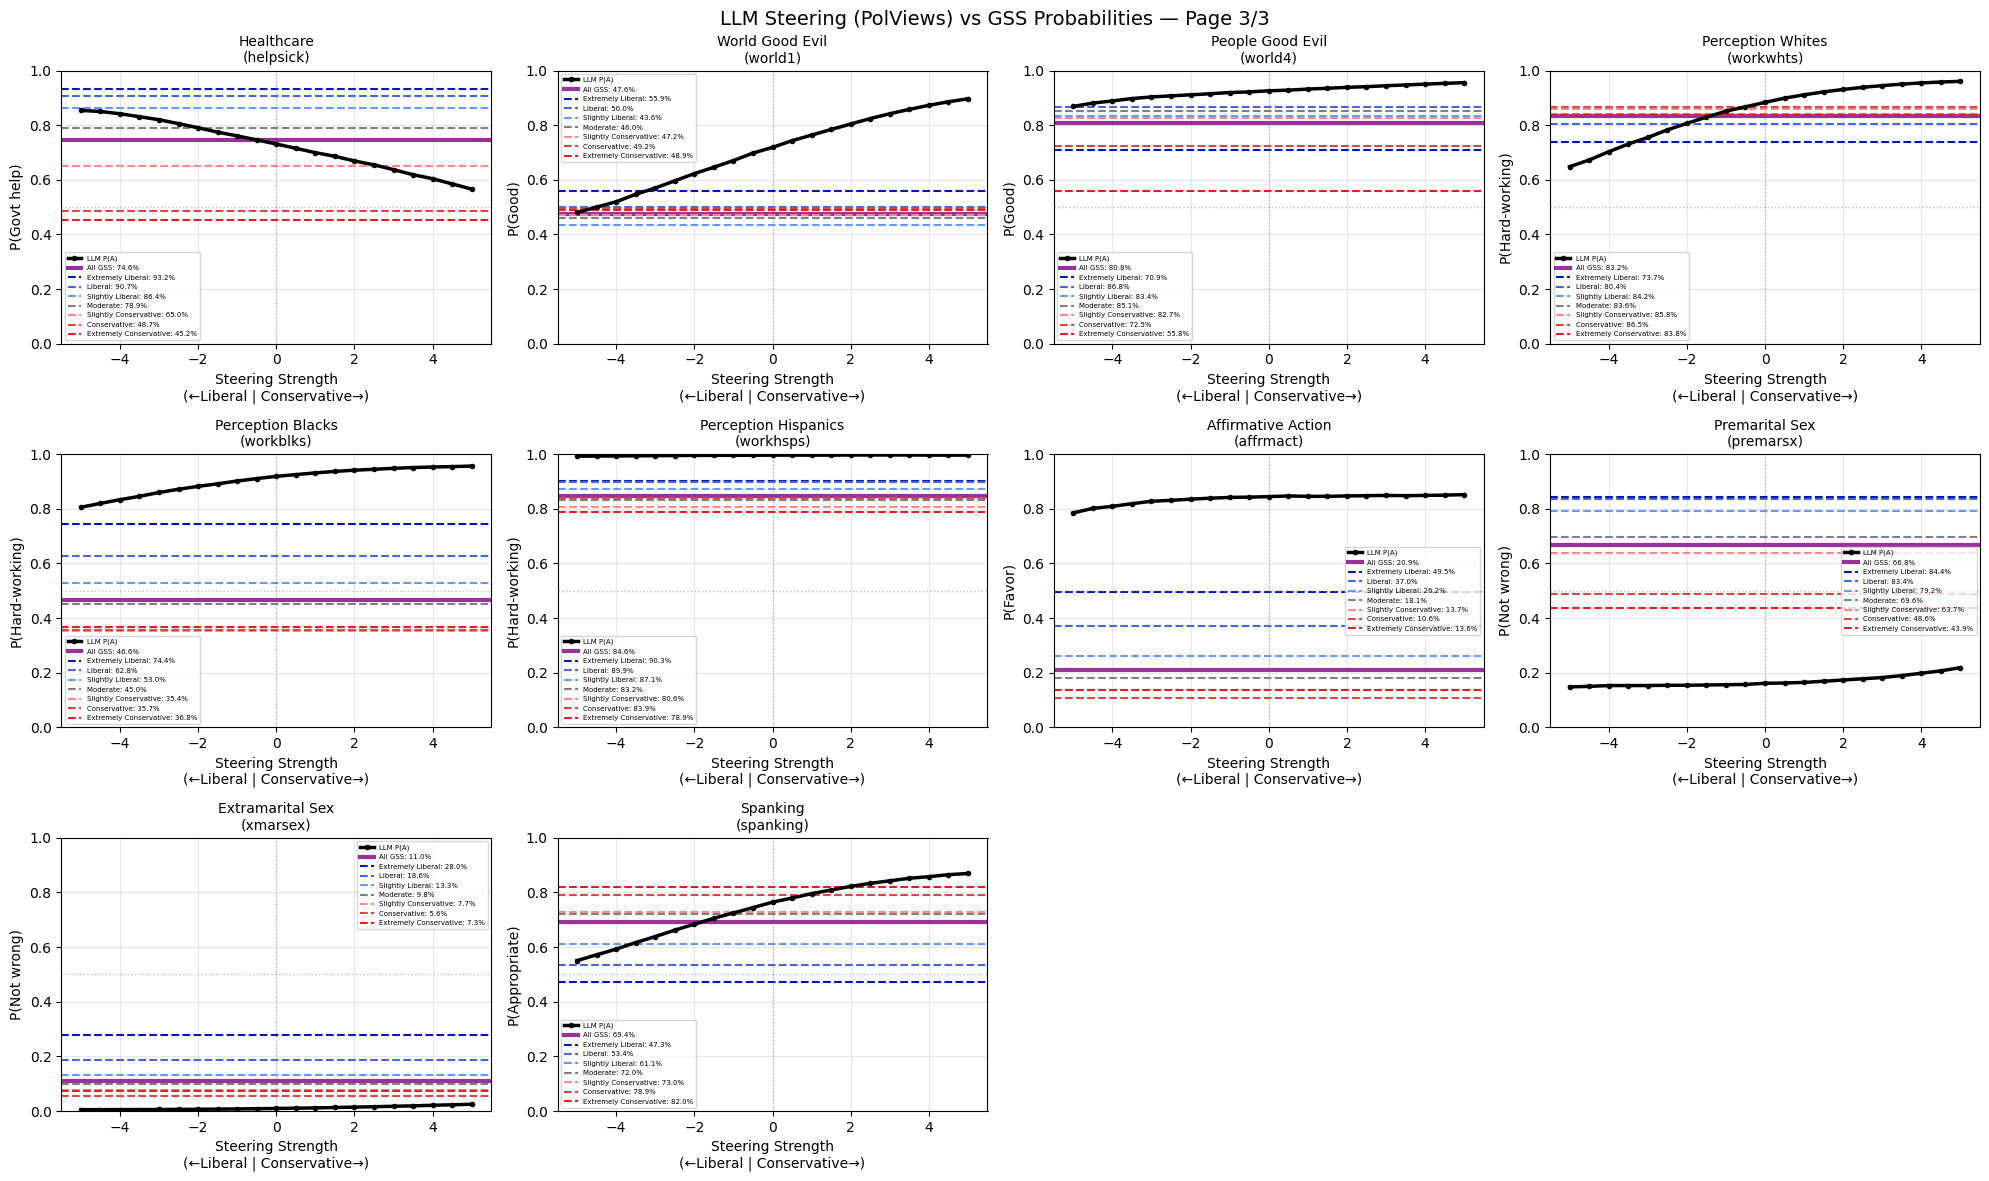

In [9]:
# Page 3: Variables 25-34
plot_steering_page(active_vars[24:], 3, 3)

In [10]:
# Compute steerability metrics
metrics = []

for var_name in active_vars:
    config = ATTITUDE_CONFIGS[var_name]
    llm_df = llm_steering_results[var_name]
    var_gss = gss_probs[var_name]

    llm_min = llm_df['prob_a'].min()
    llm_max = llm_df['prob_a'].max()
    llm_range = llm_max - llm_min

    errors = []
    all_reachable = True
    gss_pv_probs = []

    for pv_name in POLVIEWS_MAPPING:
        pv_data = var_gss.get(pv_name, {})
        target = pv_data.get('prob_a')
        if target is None:
            continue

        gss_pv_probs.append(target)
        _, error = find_optimal_strength(llm_df, target)
        errors.append(error)

        if target < llm_min or target > llm_max:
            all_reachable = False

    gss_spread = max(gss_pv_probs) - min(gss_pv_probs) if gss_pv_probs else 0
    mean_error = np.mean(errors) if errors else None
    max_error = np.max(errors) if errors else None

    group = 'Unknown'
    for g, vars_ in VARIABLE_GROUPS.items():
        if var_name in vars_:
            group = g
            break

    metrics.append({
        'variable': var_name,
        'gss_col': config['gss_col'],
        'group': group,
        'llm_range': llm_range,
        'mean_error': mean_error,
        'max_error': max_error,
        'all_reachable': all_reachable,
        'gss_spread': gss_spread,
    })

metrics_df = pd.DataFrame(metrics).sort_values('mean_error')

print('=== STEERABILITY METRICS \u2014 PolViews (sorted by mean_error, lower = more steerable) ===')
print(f'\n{"Variable":<25s} {"Group":<18s} {"LLM Range":>10s} {"Mean Err":>9s} {"Max Err":>9s} {"GSS Spread":>10s} {"Reachable":>9s}')
print('-' * 95)
for _, row in metrics_df.iterrows():
    print(f'{row["variable"]:<25s} {row["group"]:<18s} '
          f'{row["llm_range"]:>10.3f} {row["mean_error"]:>9.3f} {row["max_error"]:>9.3f} '
          f'{row["gss_spread"]:>10.3f} {"\u2713" if row["all_reachable"] else "\u2717":>9s}')

=== STEERABILITY METRICS — PolViews (sorted by mean_error, lower = more steerable) ===

Variable                  Group               LLM Range  Mean Err   Max Err GSS Spread Reachable
-----------------------------------------------------------------------------------------------
trust                     Other attitudes         0.347     0.006     0.013      0.182         ✓
perception_whites         Other attitudes         0.312     0.006     0.009      0.128         ✓
spending_crime            Spending                0.068     0.006     0.036      0.108         ✗
fairness                  Other attitudes         0.435     0.006     0.013      0.112         ✓
world_good_evil           Other attitudes         0.416     0.015     0.045      0.124         ✗
spanking                  Social issues           0.319     0.017     0.078      0.347         ✗
free_speech_racists       Social issues           0.552     0.019     0.039      0.144         ✗
bible                     Other attitude

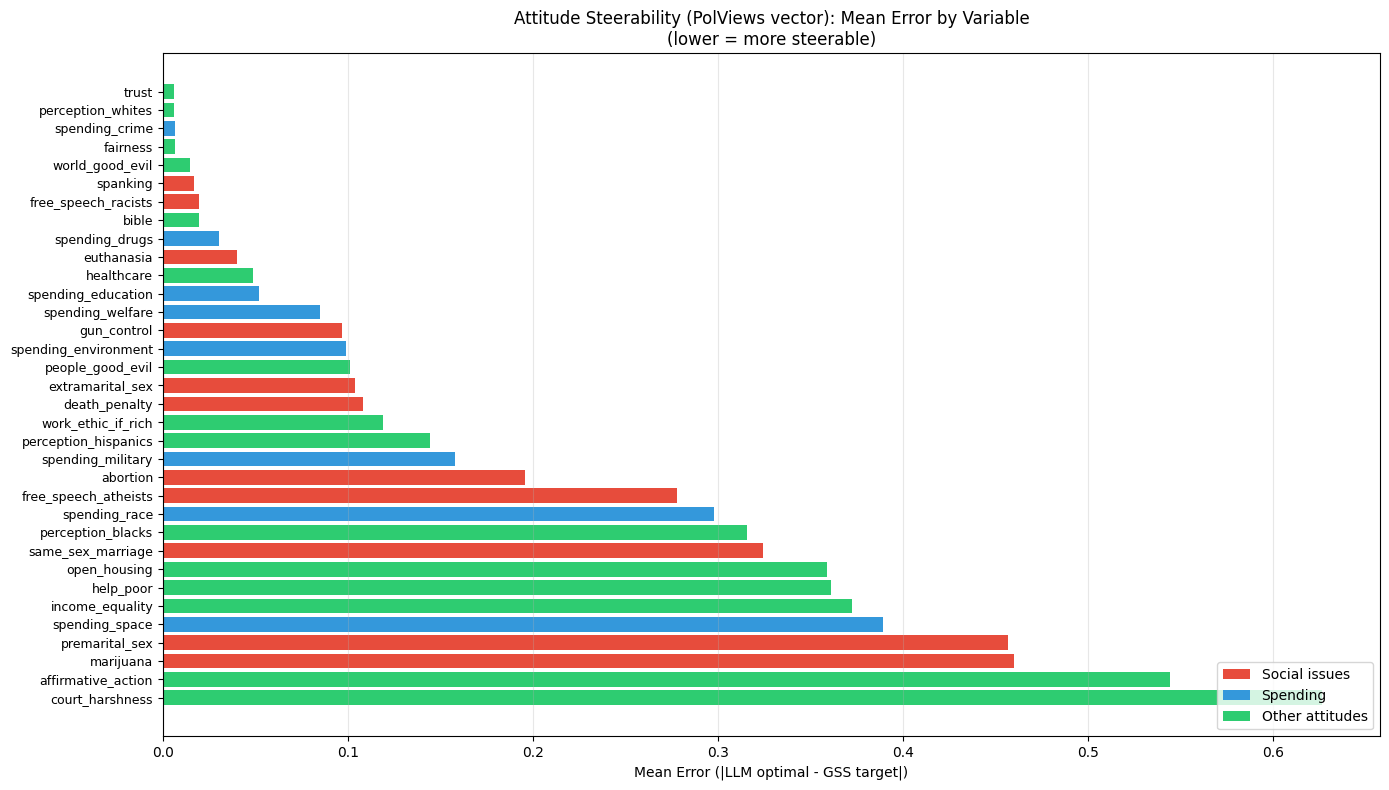

In [11]:
# Steerability summary bar chart
GROUP_COLORS = {
    'Social issues': '#E74C3C',
    'Spending': '#3498DB',
    'Other attitudes': '#2ECC71',
}

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.barh(
    range(len(metrics_df)),
    metrics_df['mean_error'],
    color=[GROUP_COLORS.get(row['group'], '#888') for _, row in metrics_df.iterrows()],
)

ax.set_yticks(range(len(metrics_df)))
ax.set_yticklabels([f'{row["variable"]}' for _, row in metrics_df.iterrows()], fontsize=9)
ax.set_xlabel('Mean Error (|LLM optimal - GSS target|)')
ax.set_title('Attitude Steerability (PolViews vector): Mean Error by Variable\n(lower = more steerable)')
ax.invert_yaxis()

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=g) for g, c in GROUP_COLORS.items()]
ax.legend(handles=legend_elements, loc='lower right')

ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

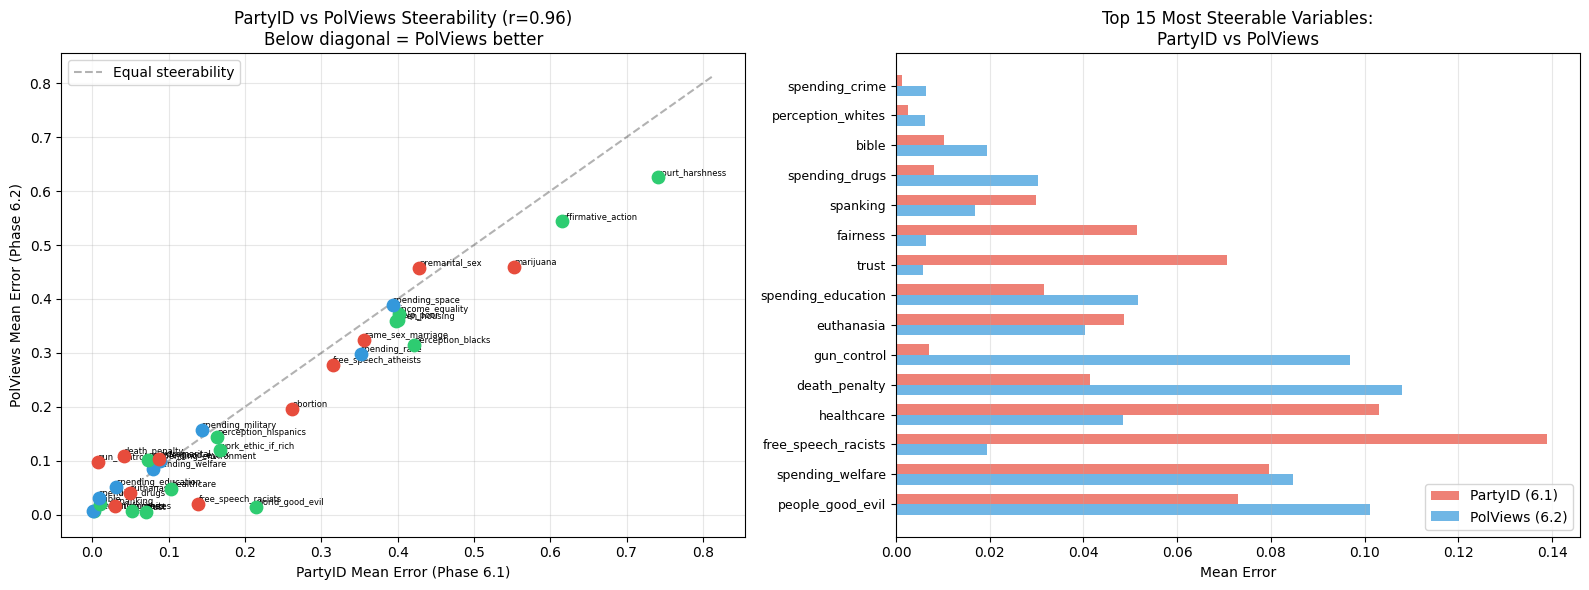


Variable                   PartyID Err  PolViews Err     Diff     Better
------------------------------------------------------------------------
spending_crime                   0.001         0.006   +0.005    PartyID
perception_whites                0.003         0.006   +0.003    PartyID
bible                            0.010         0.019   +0.009    PartyID
spending_drugs                   0.008         0.030   +0.022    PartyID
spanking                         0.030         0.017   -0.013   PolViews
fairness                         0.051         0.006   -0.045   PolViews
trust                            0.071         0.006   -0.065   PolViews
spending_education               0.032         0.052   +0.020    PartyID
euthanasia                       0.049         0.040   -0.008   PolViews
gun_control                      0.007         0.097   +0.090    PartyID
death_penalty                    0.041         0.108   +0.067    PartyID
healthcare                       0.103         0.0

In [12]:
# Compare PolViews steerability with PartyID steerability (Phase 6.1)

# Load Phase 6.1 results
partyid_results_path = os.path.join(DATA_DIR, 'attitude_steerability_results.pt')
partyid_saved = torch.load(partyid_results_path, map_location='cpu', weights_only=False)

# Reconstruct Phase 6.1 metrics
partyid_llm_results = {k: pd.DataFrame(v) for k, v in partyid_saved['llm_steering_results'].items()}
partyid_gss_probs = partyid_saved['gss_probs']

PARTYID_MAPPING = {
    'Strong Democrat': 'Strong democrat',
    'Democrat': 'Not very strong democrat',
    'Independent': 'Independent (neither, no response)',
    'Republican': 'Not very strong republican',
    'Strong Republican': 'Strong republican',
}

partyid_metrics = []
for var_name in partyid_llm_results:
    llm_df = partyid_llm_results[var_name]
    var_gss = partyid_gss_probs[var_name]

    errors = []
    for party_name in PARTYID_MAPPING:
        target = var_gss.get(party_name, {}).get('prob_a')
        if target is None:
            continue
        _, error = find_optimal_strength(llm_df, target)
        errors.append(error)

    partyid_metrics.append({
        'variable': var_name,
        'partyid_mean_error': np.mean(errors) if errors else None,
    })

partyid_metrics_df = pd.DataFrame(partyid_metrics)

# Merge with polviews metrics
comparison_df = metrics_df[['variable', 'group', 'mean_error']].rename(
    columns={'mean_error': 'polviews_mean_error'}
).merge(partyid_metrics_df, on='variable')

# Scatter plot: PartyID vs PolViews steerability
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Scatter comparison
ax = axes[0]
for _, row in comparison_df.iterrows():
    color = GROUP_COLORS.get(row['group'], '#888')
    ax.scatter(row['partyid_mean_error'], row['polviews_mean_error'], c=color, s=80, zorder=5)
    ax.annotate(row['variable'], (row['partyid_mean_error'], row['polviews_mean_error']),
                fontsize=6, ha='left', va='bottom')

# Diagonal line
lim = max(comparison_df['partyid_mean_error'].max(), comparison_df['polviews_mean_error'].max()) * 1.1
ax.plot([0, lim], [0, lim], 'k--', alpha=0.3, label='Equal steerability')

corr = comparison_df[['partyid_mean_error', 'polviews_mean_error']].corr().iloc[0, 1]
ax.set_xlabel('PartyID Mean Error (Phase 6.1)')
ax.set_ylabel('PolViews Mean Error (Phase 6.2)')
ax.set_title(f'PartyID vs PolViews Steerability (r={corr:.2f})\nBelow diagonal = PolViews better')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Panel 2: Paired bar chart (top 15 by average error)
ax = axes[1]
comparison_df['avg_error'] = (comparison_df['partyid_mean_error'] + comparison_df['polviews_mean_error']) / 2
top_df = comparison_df.sort_values('avg_error').head(15)

y = np.arange(len(top_df))
height = 0.35
ax.barh(y - height/2, top_df['partyid_mean_error'], height, label='PartyID (6.1)', color='#E74C3C', alpha=0.7)
ax.barh(y + height/2, top_df['polviews_mean_error'], height, label='PolViews (6.2)', color='#3498DB', alpha=0.7)
ax.set_yticks(y)
ax.set_yticklabels(top_df['variable'], fontsize=9)
ax.set_xlabel('Mean Error')
ax.set_title('Top 15 Most Steerable Variables:\nPartyID vs PolViews')
ax.invert_yaxis()
ax.legend(loc='lower right')
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison table
print(f'\n{"Variable":<25s} {"PartyID Err":>12s} {"PolViews Err":>13s} {"Diff":>8s} {"Better":>10s}')
print('-' * 72)
for _, row in comparison_df.sort_values('avg_error').iterrows():
    diff = row['polviews_mean_error'] - row['partyid_mean_error']
    better = 'PolViews' if diff < 0 else 'PartyID'
    print(f'{row["variable"]:<25s} {row["partyid_mean_error"]:>12.3f} {row["polviews_mean_error"]:>13.3f} '
          f'{diff:>+8.3f} {better:>10s}')

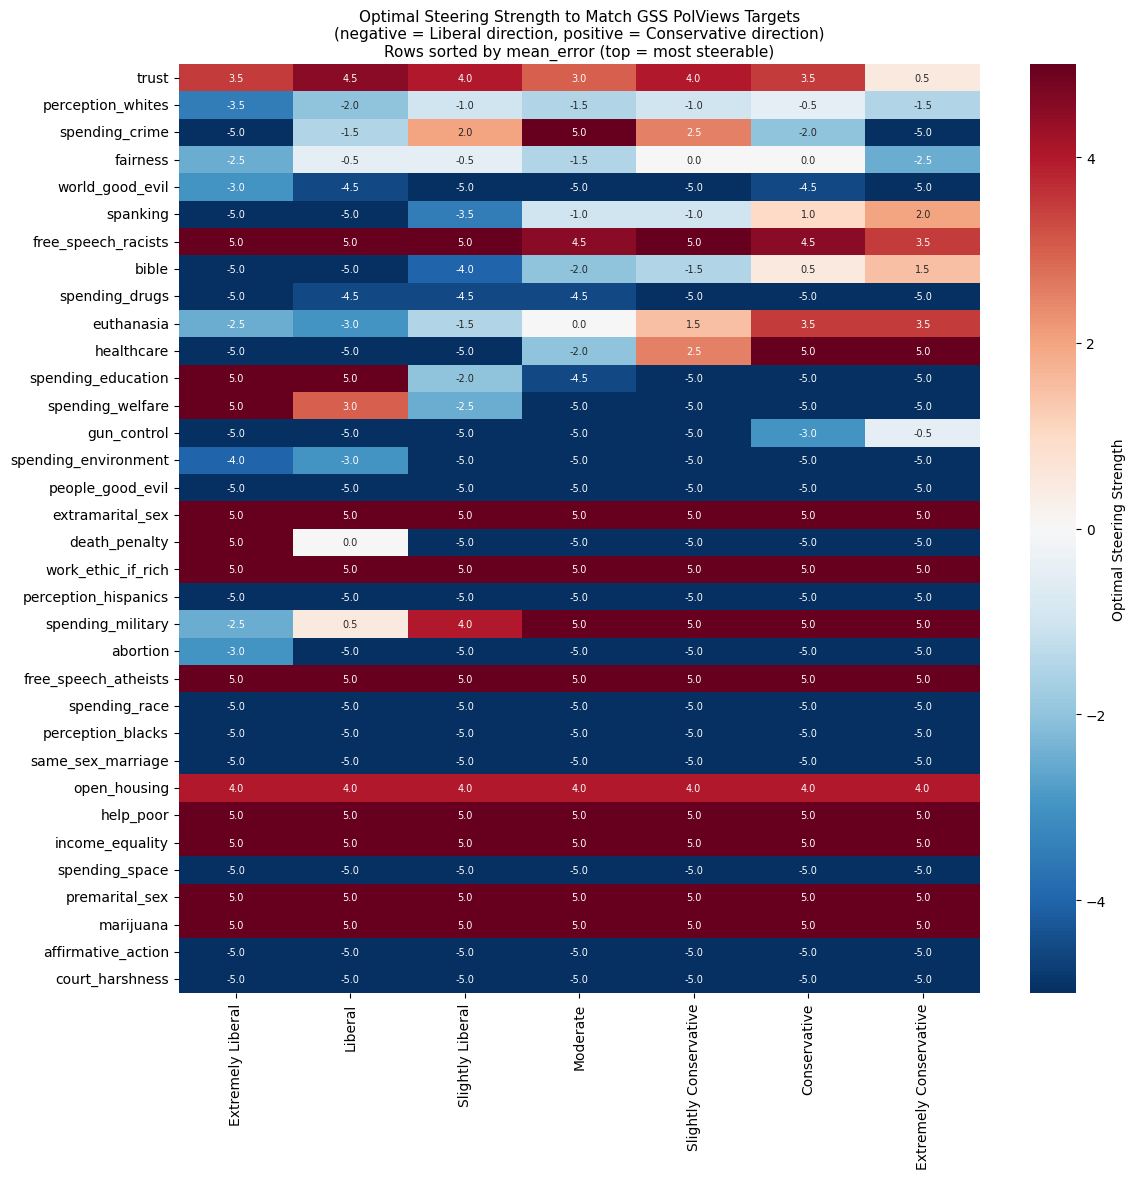

In [13]:
# Heatmap: Optimal Steering Strength per Variable x PolViews
optimal_data = []

for var_name in metrics_df['variable']:
    row = {'variable': var_name}
    llm_df = llm_steering_results[var_name]
    var_gss = gss_probs[var_name]

    for pv_name in POLVIEWS_MAPPING:
        target = var_gss.get(pv_name, {}).get('prob_a')
        strength, _ = find_optimal_strength(llm_df, target)
        row[pv_name] = strength

    optimal_data.append(row)

optimal_df = pd.DataFrame(optimal_data).set_index('variable')

fig, ax = plt.subplots(figsize=(12, max(8, len(optimal_df) * 0.35)))
sns.heatmap(
    optimal_df.astype(float),
    cmap='RdBu_r', center=0, vmin=-5, vmax=5,
    annot=True, fmt='.1f', annot_kws={'size': 7},
    cbar_kws={'label': 'Optimal Steering Strength'},
    ax=ax,
)
ax.set_title('Optimal Steering Strength to Match GSS PolViews Targets\n'
             '(negative = Liberal direction, positive = Conservative direction)\n'
             'Rows sorted by mean_error (top = most steerable)', fontsize=11)
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Summary

### Key Findings

**PolViews vs PartyID steering vectors:**
- Cosine similarity between the two contrastive vectors tells us how aligned party and ideology are in the model's latent space
- The comparison reveals which attitudes are better captured by ideological vs partisan identity

**Steerability comparison:**
- Variables where PolViews outperforms PartyID suggest the model encodes these attitudes more along an ideological axis than a partisan one
- Variables where PartyID outperforms PolViews suggest partisan identity captures something beyond ideology (e.g., group loyalty, tribal signals)
- Variables where both fail equally are likely locked by RLHF/safety training regardless of steering direction

**Note:** The PolViews vector has 7 GSS target lines (vs 5 for PartyID), providing a more fine-grained comparison but also making it harder to achieve low mean error (more targets to match).